In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import pysindy as ps
from torch.utils.data import DataLoader, TensorDataset
from functions import Solution, Rossler
from models import Autoencoder, integrator, network
from dynamical_models import RosslerSystem
import torch.nn.functional as F

In [25]:
a, b, c = 0.15, 0.2, 10
h = np.pi/100
t = np.arange(0,100,h)
n = len(t)
x0 =[0.1,1,0.1]
xs,ys,zs = Solution(Rossler, x0, t, [a,b,c])
tau = 17

sol = Solution(Rossler, x0, t, [a,b,c])
library = ps.PolynomialLibrary(degree=2)
model = ps.SINDy(feature_library=library,
                 optimizer=ps.STLSQ(threshold=0.05),
                 feature_names=["x", "y", "z"])

model.fit(sol.T, t)
model.print()

rossler_coefs = model.coefficients()

(x)' = -1.000 y + -0.998 z
(y)' = 1.000 x + 0.150 y
(z)' = 0.199 1 + -9.938 z + 0.994 x z


In [26]:
rossler = RosslerSystem(args = [0.15, 0.2, 10])
system = rossler.f
X = odeint(system, x0, t, args = ())
x_input = X[:,0]
layer_dims = [3, 100, 40, 10, 3]
tstep_pred = 40

In [27]:
ode_model = integrator(tstep_pred, np.pi/100, system=system, init_params=np.zeros_like(rossler_coefs))
encoder = network(layer_dims=layer_dims, activation= F.relu)
decoder = network(layer_dims=layer_dims[::-1], activation=F.relu)

optim_enc = torch.optim.Adam(encoder.parameters(), lr = 1e-3)
optim_ode = torch.optim.Adam(ode_model.parameters(), lr = 1e-2)
loss_fn = nn.MSELoss()

In [28]:
v1 = np.array(x_input[0: n - 2*tau]) #x(t)
v2 = np.array(x_input[tau: n - tau]) #x(t + τ)
v3 = np.array(x_input[2*tau: n]) #x(t + 2τ)

dv1 = np.gradient(v1, t[:len(v1)])
dv2 = np.gradient(v2, t[:len(v1)])
dv3 = np.gradient(v3, t[:len(v1)])

v = torch.tensor(np.array([v1, v2, v3]), dtype=torch.float32, requires_grad=True).T
dvdt = torch.tensor(np.array([dv1, dv2, dv3]), dtype=torch.float32, requires_grad=True).T
dataset = TensorDataset(v, dvdt)
dataloader = DataLoader(dataset, batch_size=1500, shuffle=False)

In [29]:
sindyae = Autoencoder(tau, ode_model=ode_model, loss_fn=loss_fn, optim_enc=optim_enc, optim_ode=optim_ode, tstep_pred=tstep_pred,
                                  encoder=encoder, decoder=decoder,
                                  l={'x0':1, 'cons': 1, 'l1': 1e-1, 'recon': 1e-1, 'x_dot': 1e-1, 'v_dot': 1e-1})

In [30]:
torch.manual_seed(123)

In [31]:
for epoch in range(100):
    total_loss = 0
    for v_batch, dvdt_batch in dataloader:
        Loss = sindyae.loss(v_batch, dvdt_batch)
        Loss.backward()
        optim_enc.step()
        optim_ode.step()
        optim_enc.zero_grad()
        optim_ode.zero_grad()
        total_loss += Loss.item() 
    average_loss = total_loss / len(dataloader)
    if (epoch+1) % 10== 0:
         print(f"Epoch [{epoch+1}/{100}], Loss: {average_loss:.4f}")

Epoch [10/100], Loss: 88.3833
Epoch [20/100], Loss: 52.7715
Epoch [30/100], Loss: 37.4803
Epoch [40/100], Loss: 26.9181
Epoch [50/100], Loss: 21.4536
Epoch [60/100], Loss: 15.1793
Epoch [70/100], Loss: 11.9681
Epoch [80/100], Loss: 10.9138
Epoch [90/100], Loss: 10.7031
Epoch [100/100], Loss: 10.6523


In [32]:
encoder.eval() 
ode_model.eval()
latent_variables = encoder(v)
x_ae = latent_variables[:,0].detach().numpy()
y_ae = latent_variables[:,1].detach().numpy()
z_ae = latent_variables[:,2].detach().numpy()

In [33]:
latent_library = ps.PolynomialLibrary(degree = 2)
latent_model = ps.SINDy(feature_library=latent_library,
                        optimizer=ps.STLSQ(threshold=0.1),
                        feature_names=["x", "y", "z"])
latent_model.fit(latent_variables.detach().numpy(), t[:len(latent_variables.detach().numpy())])
latent_model.print()
latent_coef = latent_model.coefficients()

(x)' = 0.397 1 + -1.025 y + -11.624 z + -1.520 y z + 31.053 z^2
(y)' = 0.769 1 + 1.133 x + 0.135 y + -10.138 z + -0.921 x z + -1.695 y z + 23.198 z^2
(z)' = -1.268 z + -0.373 y z + 10.953 z^2


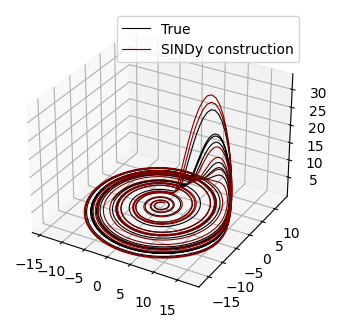

In [34]:
latent_sol = odeint(system, latent_variables[0].detach().numpy(), t, args = (latent_coef,))
fig = plt.figure(figsize=(13, 13))
ax3d = fig.add_subplot(1, 3, 1, projection='3d')
ax3d.plot(X[:,0], X[:,1], X[:,2], color = "k", label = "True", lw = .8)
ax3d.plot(latent_sol[:,0], latent_sol[:,1], latent_sol[:,2], color ='maroon', label = "SINDy construction", lw = .8)
plt.legend()
plt.show()